### 모듈들을 임포트합니다. 
작성자는 cifar10 파일을 Hvass-Lab에서 받았기에  Havass-Lab의 Repository를 아래에 첨부합니다.

https://github.com/Hvass-Labs/TensorFlow-Tutorials

In [1]:
import tensorflow as tf
import numpy as np
import prettytensor as pt
import master.cifar10 as cifar10 ## 작성자의 경우 master라는 풀더 안에 cifar10.py를 설치했기에 불러오기 편하도록 이 코드를 사용했습니다.
import os
import time
from datetime import timedelta

### cifar10 파일을 다운받고, 학습 데이터들과 평가 데이터들을 불러옵니다.

In [2]:
cifar10.maybe_download_and_extract()

classes_name = cifar10.load_class_names()

images_train,cls_train,labels_train = cifar10.load_training_data()

images_test,cls_test,labels_test = cifar10.load_test_data()

Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


### Parameter들을 정의해줍니다 (batch 사이즈와 epoch의 사이즈는 자신의 컴퓨터에 맞게 설정해주시면 됩니다.)

In [3]:
img_size = 32
num_channels = 3
num_classes = len(classes_name)
batch_size = 20
training_epoch = 100
num_train = len(images_train)
learning_rate = 0.0002
keep_prob = tf.placeholder(tf.float32) ## drop out을 하기위해 변수를 정의합니다.
logs_path = './logs_cifar10'

### 데이터들을 골고루 썩어주기 위해 Shuffle_data함수를 정의합니다.

In [4]:
def shuffle_data():
    idx = np.random.permutation(num_train)
    
    train_ig = images_train[idx]
    train_cls = cls_train[idx]
    train_lb = labels_train[idx]
    
    return train_ig, train_cls, train_lb

### 학습에 사용되는 데이터의 수를 늘리기 위해 전처리 함수를 만듭니다. 전처리를 할 경우 메모리가 많이 필요하니, 
### 메모리가 부족한 분들은 생략해도 상관없습니다.

In [5]:
def preprocess_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image,max_delta = 0.5)
    image = tf.image.random_contrast(image,lower = 0.3, upper = 1.0)
    image = tf.image.random_brightness(image,max_delta = 0.2)
    image = tf.image.random_saturation(image,lower = 0.0, upper = 2.0)
    image = tf.minimum(image,1.0)
    image = tf.maximum(image,0.0)
    
    return image    

def preprocess(images):
    images = tf.map_fn(lambda image: preprocess_image(image), images)
    return images

### Inception Net의 경우 아래 사진과 같은 단위들이 반복되기에 아래의 단위를 함수로 만들어 사용하는 것이 편합니다.
#### 앞으로 여러장의 사진들을 사용할 것인데 그 사진들의 출처는 다음과 같습니다.
출처: Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed, Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, Andrew Rabinovich(2014/09/17), Going Deeper with Convolutions

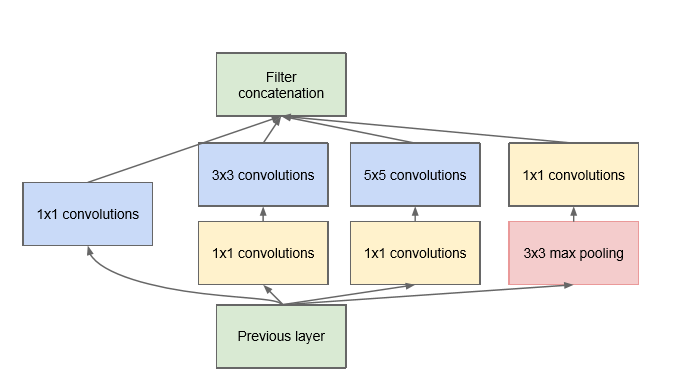

In [6]:
from IPython.display import Image
Image("inception.png")

In [7]:
def inception_modules(images_input,depth_1,depth_2):        
    pretty = pt.wrap(images_input)
        
    ## seq는 images_input이 각각의 컨볼루션 레이어를 통과한 후 출력되어지는 벡터들을 합친 레이어를 나태냅니다.(concatenated layer)
    seq = pretty.sequential()
        
    with seq.subdivide(4) as [A,B,C,D]: ## 4개의 분기를 만들고, 분기들의 이름을 각각 A,B,C,D로 정의합니다.

        A.conv2d([1,1],depth_2)
            

        ## 3x3의 filter 사이즈를 사용하는 것보다 1X3, 3X1을 한 번씩 사용하는 것이 연산량이 더 적으므로 아래와 같이 작성하였습니다. 
        B.conv2d([1,1],depth_1).conv2d([1,3],depth_2).conv2d([3,1],depth_2)
            

        ## 5X5의 filter 사이즈를 사용하는 것보다 3X3을 두 번 사용하는 것이 효율이 더 좋으므로 아래와 같이 작성하였습니다.
        C.conv2d([1,1],depth_1).conv2d([1,3],depth_2).conv2d([3,1],depth_2).conv2d([1,3],depth_2).conv2d([3,1],depth_2)
            

        D.max_pool([3,3],1).conv2d([1,1],depth_2)
        
    return seq    

### network 초기에는 inception방법의 효율이 안좋아 아래와 같은 네트워크를 사용합니다(바로 아래 사진).
### 또한, inception network의 경우 weights 와 biases들을 더욱 잘 학습할 수 있도록 하기 위해, 여러개의 softmax함수를 사용합니다(아래 두번째 사진). 이 튜토리얼에서는 중간에 있는 softmax함수는 생략했습니다.
#### ※이 튜토리얼에서는 논문에서 사용했던 이미지가 아닌 (None,32,32,3) 크기의 이미지를 사용하므로 기존의 네트워크를 조금 수정하였습니다.


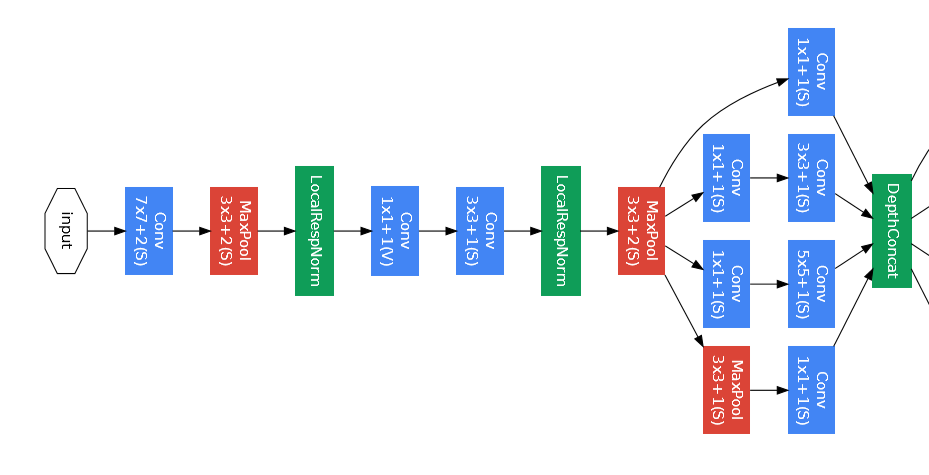

In [8]:
from IPython.display import Image
Image("inception_start.png")

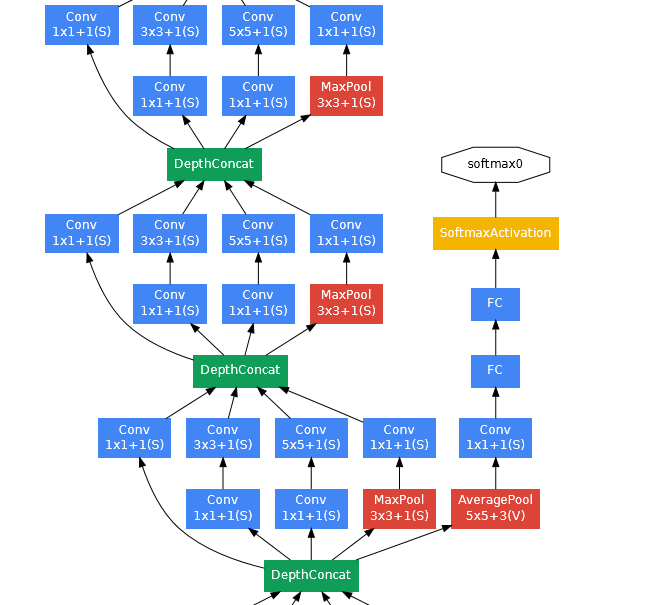

In [9]:
from IPython.display import Image
Image("softmax.png")

In [10]:
# 변수를 정의해줍니다.
X_img = tf.placeholder(tf.float32, shape = [None,img_size,img_size,num_channels], name = "Input_images")
Y = tf.placeholder(tf.float32, shape = [None, num_classes], name = "pred_labels")

with pt.defaults_scope(activation_fn = tf.nn.relu):
    ## 1*1 convolution layer는 3x3 or 5x5의 convolution layer의 연산량을 줄이기 위해 사용합니다..
    ## 아래의 코드는 inception_modules에 들어가기 전까지의 과정을 약간 수정하여 작성한 것 입니다.
    ## 실행이 끝난 후 레이어의 크기는 [None,16,16,192]입니다.
    ## 풀링을 기준으로 하여 주석을 작성하였습니다.
    pretty_X_img = pt.wrap(X_img)
    hidden_layer1 = pretty_X_img.conv2d([3,3],64,weights = tf.contrib.layers.xavier_initializer()).\
    conv2d([1,1],32,batch_normalize = True).\
    conv2d([3,3],192).\
    conv2d([1,1],192, batch_normalize = True).\
    max_pool([2,2],2)
            
    ## 실행 후 레이어의 크기는 [None,16,16,480]입니다.
    hidden_layer2_1 = inception_modules(hidden_layer1,128,256)
    hidden_layer2_2 = inception_modules(hidden_layer2_1,240,480)
    
    ## 원래는 max_pool의 stride를 2로 사용해야하는데,이 경우는 조금 수정하여 1을 사용했습니다.
    ## 실행 후 레이어의 크기는 [None,16,16,512]입니다.
    hidden_layer_pooling1 = hidden_layer2_2.max_pool([3,3],1)
    hidden_layer3_1 = inception_modules(hidden_layer_pooling1,256,512)
    
    ## 실행 후 레이어의 크기는 [None,16,16,832]입니다.
    hidden_layer3_2 = inception_modules(hidden_layer3_1,256,512)
    hidden_layer3_3 = inception_modules(hidden_layer3_2,256,512)
    hidden_layer3_4 = inception_modules(hidden_layer3_3,264,528)
    hidden_layer3_5 = inception_modules(hidden_layer3_4,416,832)
    
    ## 실행이 끝난 후 이미지의 크기는 [None,8,8,1024]입니다.
    hidden_layer_pooling2 = hidden_layer3_5.max_pool([3,3],2)
    hidden_layer4_1 = inception_modules(hidden_layer_pooling2,416,832)
    hidden_layer4_2 = inception_modules(hidden_layer4_1,512,1024)
    
    ## weight와 bias들을 튜닝하기 편하도록 softmax0 와 cost0를 출력합니다. 이 때 fully_connected_layer는 1개만 사용했습니다.
    softmax0,cost0 = hidden_layer3_1.average_pool([5,5],3).conv2d([1,1],256).flatten().\
    fully_connected(1000).softmax_classifier(num_classes = num_classes, labels =Y)
    
    ## hidden_layer4_2를 8*8, stride = 1로 average_pooling한 다음 dropout을 해줍니다. 그 이후 fully_connected에 들어갈 수 있도록
    ## flatten해주고 pretty tensor의 softmax_classifier를 이용해 softmax1과 cost1를 출력합니다. 
    softmax1,cost1 = hidden_layer4_2.average_pool([8,8],1).dropout(keep_prob = keep_prob).flatten().fully_connected(1000).\
    softmax_classifier(num_classes = num_classes, labels =Y)
    
## cost 값을 최적화를 위해 하나의 값으로 만들어 줍니다.
cost = (cost0 + cost1)/2

is_correct_train = tf.equal(tf.argmax(softmax1,1), tf.argmax(Y,1))
Accuracy_train = tf.reduce_mean(tf.cast(is_correct_train, dtype = tf.float32))

### AdamOptimizer를 사용하여 cost를 최적화합니다.

In [11]:
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

### Cost 값의 추의를 보기 위해 Tensorboard를 사용합니다.

In [12]:
sum_list = []
sum_list.append(tf.summary.scalar("Cost", cost))
sum_list.append(tf.summary.scalar("Accuracy_train",Accuracy_train))
summary = tf.summary.merge(sum_list)

### Session을 실행시키고 변수들을 초기화 합니다.

In [13]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())

### writer를 정의해줍니다.

In [14]:
writer = tf.summary.FileWriter(logs_path)
saver = tf.train.Saver()

### 이미지를 전처리하여 데이터 셋을 10만개로 만듭니다(기존의 이미지 5만개 + 전처리를 한 이미지 5만개 = 10만개).

In [15]:
images_distorted,cls_shuffled,labels_shuffled = shuffle_data()
images_distorted = np.concatenate([images_train,images_distorted], axis = 0)
cls_shuffled = np.concatenate([cls_train,cls_shuffled], axis = 0)
labels_shuffled = np.concatenate([labels_train,labels_shuffled], axis = 0)

### 데이터를 한번에 학습 시키지 못하기 때문에(메모리 문제)  아래와 같이 Batch를 만들어 학습시켜 줍니다.

In [ ]:
for epoch in range(training_epoch):
    start_time = time.time()
    cost_val = 0
    total_batch = int(len(images_distorted)/ batch_size)    
    for j in range(total_batch):
        
        ## 한 에폭의 학습 진행상황을 보기위한 print문입니다.
        if (j+1) % 5 ==0:
            percent = ((j+1)/total_batch)*100
            print("EPOCH training rate: " + format(percent,'0.2f') + " %", end = "\r", flush = True)
            
        batch_xs = images_distorted[batch_size*j:batch_size+batch_size*j]
        batch_ys = labels_shuffled[batch_size*j:batch_size+batch_size*j]
        
        ## dropout을 40%하여 오버피팅을 방지하고 정확도를 높힙니다. 또한 tensorboard 실행을 위한 코드를 작성해 줍니다.
        c,a,s,_ = sess.run([cost,Accuracy_train,summary,optimizer], feed_dict = {X_img: batch_xs, Y:batch_ys, keep_prob:0.6})
        writer.add_summary(s,epoch*total_batch+j)
        cost_val += c/total_batch                
    print("EPOCH: ", epoch,"Cost_val: ", cost_val)
    save_path = saver.save(sess,'.\Cifar10.ckpt')
    print(os.getcwd())
    print("Model saved in file: ", save_path)
    print("complete_saving")
    
    ## 1 Epoch를 계산하는데 드는 시간을 계산하기 위한 파이썬 코드를 작성합니다.
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage to calculate the Epoch: " + str(timedelta(seconds=int(round(time_dif)))))
    print("----------------------------------------------------")
    
print("learning_finished")
print("----------------------------------------------------")

EPOCH:  0 Cost_val:  1.24292742576
C:\Users\MinGuk\Documents
Model saved in file:  .\Cifar10.ckpt
complete_saving
Time usage to calculate the Epoch: 0:34:20
----------------------------------------------------
EPOCH:  1 Cost_val:  0.66015380206


### 학습결과를 평가하기 위해 softmax1를 출력하는 파이썬 코드를 작성합니다.

In [16]:
softmax1_batch = 100 ## 작성자의 경우 메모리 부족현상으로 인해 배치를 만들어 softmax1를 계산했습니다.
for k in range(int(len(images_test)/softmax1_batch)):
    
    ## softmax1를 계산하기 위한 Batch를 만듭니다.
    batch_test_images = images_test[softmax1_batch*k:softmax1_batch*k + softmax1_batch]
    batch_test_labels = labels_test[softmax1_batch*k:softmax1_batch*k + softmax1_batch]
    
    ## softmax1_val를 계산합니다. 평가를 할때는 모든 데이터를 다 사용해야하므로 keep_prob = 1로 작성합니다.
    softmax1_val = sess.run([softmax1], feed_dict = {X_img:batch_test_images, Y:batch_test_labels,keep_prob: 1})
    
    ## Batch를 이용해 계산되 softmax1_val를 합치기 위해서 다음과 같은 코드를 작성합니다.
    if k == 0:
        softmax1_saver = softmax1_val
    else:
        softmax1_saver = np.concatenate([softmax1_saver,softmax1_val], axis = 1) 

## 출력된 softmax1_saver의 모양은 (1,10000,10)인데, 이를 reshape하여 (10000,10)으로 만들어 줍니다.
softmax1_saver = softmax1_saver.reshape(len(images_test), num_classes)

ERROR! Session/line number was not unique in database. History logging moved to new session 417


### 출력된 softmax1를 이용하여 정확도(Accuracy)를 계산하고 출력합니다.

In [17]:
is_correct = tf.equal(tf.argmax(softmax1_saver,1),tf.argmax(labels_test,1))
Accuracy = tf.reduce_mean(tf.cast(is_correct, dtype = tf.float32))
Accuacy_val = sess.run([Accuracy])
print(Accuacy_val)

[0.77649999]
